# Proyecto 04 - Series de Tiempo


### Creado por: Josefina Panettieri
#### josefinapanettieri86@gmail.com

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

A través de la implementación de otras tecnicas se buscará obtener un modelo cuya capacidad de realizar predicciones sea más elevada que el obtenido en el proyecto antes mencionado. 


##### Estructura del proyecto:

El proyecto se separa en 4 partes: 
- **Parte A:** Análisis Exploratorio de los Datos.
- **Parte B:** Presentación, modelado y evaluación de los modelos.
- **Parte C:** Comparación de resultados y conclusiones.
 
    



### Parte A
 
#### Exploración de datos

[Ver el proyecto anterior](https://github.com/josefinapanettieri/Acamica/blob/main/DS_Proyecto_03_Panettieri.ipynb)

#### Componentes de la serie

[Ver el proyecto anterior](https://github.com/josefinapanettieri/Acamica/blob/main/DS_Proyecto_03_Panettieri.ipynb) 

In [75]:
#importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
import datetime
import itertools

In [3]:
#cargamos data
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [4]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB


,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0
1,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0
2,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0
3,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0
4,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0



Vamos a trabajar con la estación Illia y la forma de pago Efectivo

In [33]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]
#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
diario

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486
...,...
2019-12-27,40182
2019-12-28,30681
2019-12-29,26259


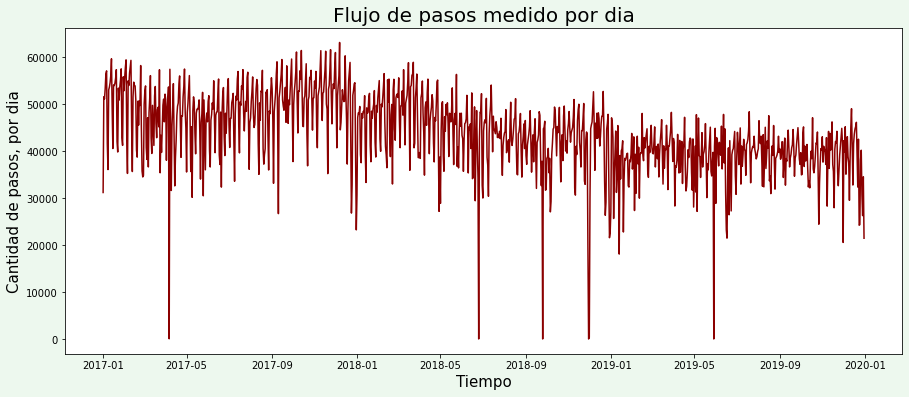

In [42]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos,color="darkred")
plt.title('Flujo de pasos medido por dia',color= 'black', fontsize= 20)
plt.xlabel('Tiempo', fontsize=15)
plt.ylabel('Cantidad de pasos, por dia',fontsize=15 )
plt.rcParams['figure.facecolor'] = '#edf8ee'
plt.show()

Observamos la presencia de atipicos los cuales vamos a eliminar para poder trabajar mejor.


In [44]:
# Convertimos los valores outlier en valores Faltantes
diario.cantidad_pasos[diario.cantidad_pasos<10000]=np.nan

In [45]:
# Interpolamos la serie para que no hayan valores faltantes
diario= diario.interpolate()


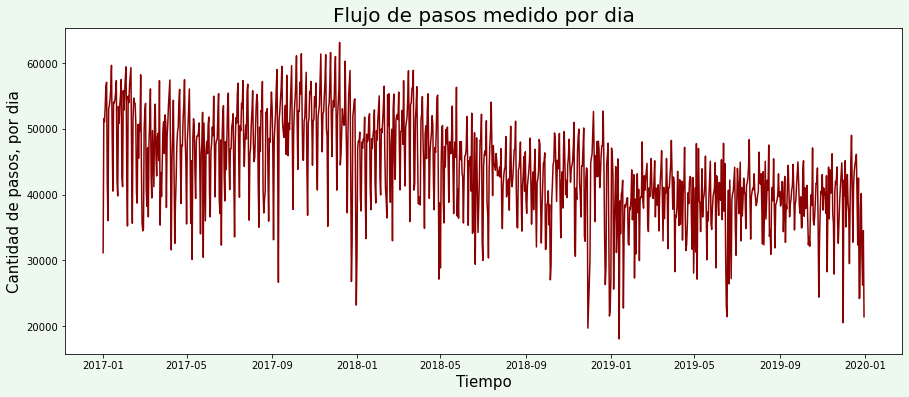

In [46]:
#Graficamos nuevamente
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos,color="darkred")
plt.title('Flujo de pasos medido por dia',color= 'black', fontsize= 20)
plt.xlabel('Tiempo', fontsize=15)
plt.ylabel('Cantidad de pasos, por dia',fontsize=15 )
plt.rcParams['figure.facecolor'] = '#edf8ee'
plt.show()

Corroboramos la correcta eliminacion de outliers.

### Analizamos en 2020

In [47]:
#Sobre la estacion Illia
dataset_2020 =data_2020[data_2020.estacion=='ILLIA']
dataset_2020.describe(include='all')

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
count,296053.0,296053,296053,296053,296053.000000,296053.000000,296053.000000,296053,296053,296053,296053,296053,296053.000000
unique,NaN,366,12,7,NaN,NaN,NaN,1,12,8,22,2,NaN
top,NaN,2020-02-21 00:00:00,enero,Miércoles,NaN,NaN,NaN,ILLIA,Auto,Tag,Tag - PosPago,Centro,NaN
freq,NaN,1212,31057,46632,NaN,NaN,NaN,296053,133478,135838,66258,153134,NaN
mean,2020.0,NaN,NaN,NaN,15.717733,12.158566,12.406268,NaN,NaN,NaN,NaN,NaN,60.665192
std,0.0,NaN,NaN,NaN,8.779484,6.243732,6.337303,NaN,NaN,NaN,NaN,NaN,191.956546
min,2020.0,NaN,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,2020.0,NaN,NaN,NaN,8.000000,7.000000,8.000000,NaN,NaN,NaN,NaN,NaN,1.000000
50%,2020.0,NaN,NaN,NaN,16.000000,12.000000,13.000000,NaN,NaN,NaN,NaN,NaN,4.000000
75%,2020.0,NaN,NaN,NaN,23.000000,17.000000,18.000000,NaN,NaN,NaN,NaN,NaN,20.000000


In [48]:
#Sobre la estacion Illia
dataset_2020['forma_pago'].value_counts()

Tag                  135838
Efectivo              52374
Violación             37272
Rec.Deuda             30694
Exento                23745
Tarjeta Magnética     10899
CPP                    2913
Mercado Pago           2318
Name: forma_pago, dtype: int64

Aqui podemos ver que la forma de pago preponderante es TAG (telepase). Esto quiza lo podemos vincular a un beneficio del 20% del descuento con este medio de pago.
A partir del 28/09/2020 el uso de Telepase es Obligatorio en las Autopistas que dependen de AUSA, siendo el costo del peaje un 55% menor que si se abona en Efectivo

In [49]:
data20=data_2020[(data_2020.estacion=='ILLIA')& (data_2020.forma_pago == 'Efectivo')]
data20

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
52,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Centro,326.0
53,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319.0
134,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,1.0,2.0,ILLIA,Auto,Efectivo,Efectivo,Centro,199.0
135,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,1.0,2.0,ILLIA,Auto,Efectivo,Efectivo,Provincia,180.0
202,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,2.0,3.0,ILLIA,Auto,Efectivo,Efectivo,Centro,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532216,2020.0,2020-12-24,diciembre,Jueves,24.0,11.0,12.0,ILLIA,Pesados 6 Ejes,Efectivo,Efectivo,Provincia,1.0
2532227,2020.0,2020-12-24,diciembre,Jueves,24.0,12.0,13.0,ILLIA,Pesados 6 Ejes,Efectivo,Efectivo,Provincia,1.0
2532271,2020.0,2020-12-24,diciembre,Jueves,24.0,17.0,18.0,ILLIA,Pesados 6 Ejes,Efectivo,Efectivo,Centro,1.0
2532928,2020.0,2020-12-28,diciembre,Lunes,28.0,12.0,13.0,ILLIA,Pesados 6 Ejes,Efectivo,Efectivo,Provincia,1.0


In [50]:
#sacamos las columnas que no vamos a usar
data20.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace=True)
#Pasamos la columna fecha a formato datetime
data20['fecha2'] = pd.to_datetime(data20.fecha) + pd.to_timedelta(data20.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data20.drop(columns=['fecha','hora_fin','dia_fecha'], inplace = True)
#Corregimos el nombre de fecha2 a fecha
data20.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos por fecha
data20.sort_values('fecha', inplace = True)
data20.reset_index(drop=True, inplace = True)
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
data20 = data20.resample('D', on = 'fecha').sum()
data20.head()

C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-50-a5e1748999e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data20['fecha2'] = pd.to_datetime(data20.fecha) + pd.to_timedelta(data20.hora_fin, unit = 'h')
C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

,cantidad_pasos
fecha,
2020-01-01,21395.0
2020-01-02,33722.0
2020-01-03,37067.0
2020-01-04,30627.0
2020-01-05,27812.0


### Analisis Formas de Pago

In [51]:
#Forma de Pago Efectivo
# Al igual que con los datos anteriores, trabajamos con semanal media
semanal_20 =data20.resample('W').mean()
print(semanal_20.shape)
semanal_20.head()



(53, 1)


,cantidad_pasos
fecha,
2020-01-05,30124.600000
2020-01-12,34765.571429
2020-01-19,35259.714286
2020-01-26,34456.000000
2020-02-02,36190.714286


In [52]:
#forma de pago telepase
#creamos dataser tag
data20_t=data_2020[(data_2020.estacion=='ILLIA')& (data_2020.forma_pago == 'Tag')]
#Quitamos las columnas que no vamos a utilizar
data20_t.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data20_t['fecha2'] = pd.to_datetime(data20_t.fecha) + pd.to_timedelta(data20_t.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data20_t.drop(columns=['fecha','hora_fin','dia_fecha'], inplace = True)
#Corregimos el nombre de fecha2 a fecha
data20_t.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos el d_2020_t por fecha
data20_t.sort_values('fecha', inplace = True)
data20_t.reset_index(drop=True, inplace = True)
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
data20_t = data20_t.resample('D', on = 'fecha').sum()
semanal_20_t =data20_t.resample('W').mean()
print(semanal_20_t.shape)
semanal_20_t.head()

(53, 1)


C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-52-d31ed500bd5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data20_t['fecha2'] = pd.to_datetime(data20_t.fecha) + pd.to_timedelta(data20_t.hora_fin, unit = 'h')
C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

,cantidad_pasos
fecha,
2020-01-05,33239.600000
2020-01-12,45275.714286
2020-01-19,46034.857143
2020-01-26,45056.285714
2020-02-02,47610.142857


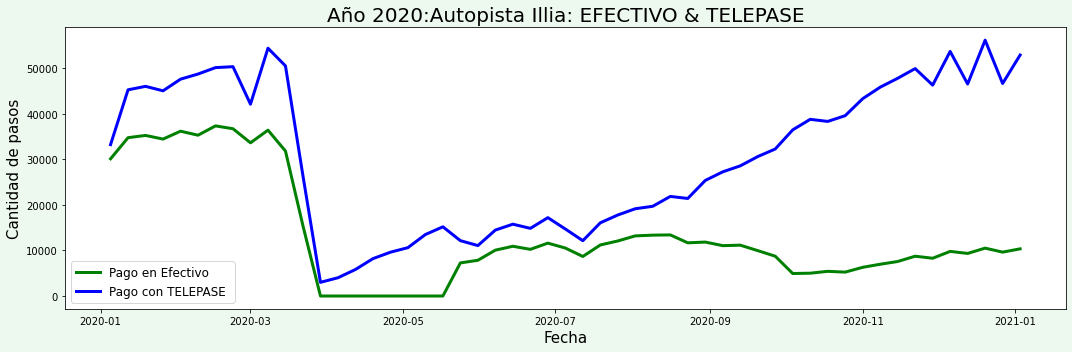

In [53]:
# VIsualizacion de las tendencias 
plt.figure(figsize=(15,5))
plt.plot(semanal_20.index, semanal_20.cantidad_pasos,lw=3,color='green', label='Pago en Efectivo')
plt.plot(semanal_20_t.index, semanal_20_t.cantidad_pasos, lw=3, color='blue',label='Pago con TELEPASE ')
plt.title ('Año 2020:Autopista Illia: EFECTIVO & TELEPASE', color='black', fontsize=20)
plt.xlabel('Fecha', color='black',fontsize=15)
plt.ylabel('Cantidad de pasos', color='black',fontsize=15)
plt.rcParams['figure.facecolor'] = '#edf8ee'

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Aqui podemos ver un tendecia en aumento con la forma de pago tag, quiza relacionada con los motivos que expusimos anteriormente relacionados a beneficios con dicho medio de pago.


In [54]:
diario_2020= pd.concat([diario, data20])
diario_2020

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0
...,...
2020-12-27,8434.0
2020-12-28,10311.0
2020-12-29,12036.0


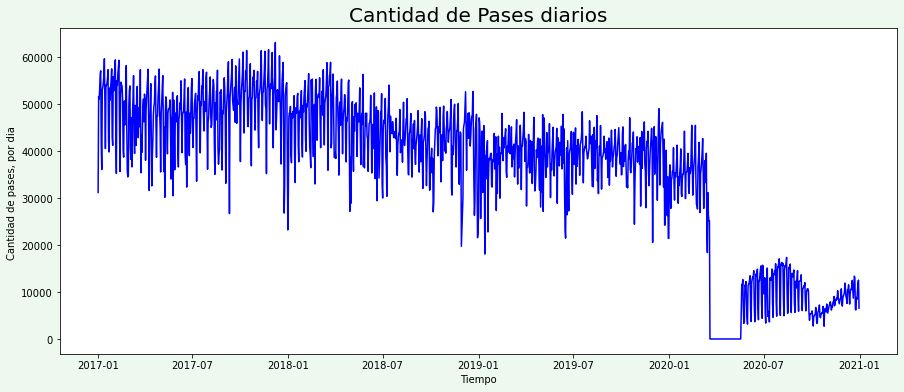

In [55]:
#Vizualizamos
plt.figure(figsize = (15,6))
plt.plot(diario_2020.index, diario_2020.cantidad_pasos,color='blue')
plt.title("Cantidad de Pases diarios", fontsize= 20)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pases, por dia ')
plt.show()

Podemos observar a simple vista el efecto de la cuarentena dictada en marzo del 2020 producto de la pandemia por COVID-19 y como comienza a subir levemente la circulacion a medida que se fueron reestableciendo algunas actividades hacia jumio/julio del 2020.
Nunca se llegan a alcanzar los valores pre-pandemia.

In [57]:
#resampleamos 
semanal_20 =diario_2020.resample('W').mean()
print(semanal_20.shape)
semanal_20

(210, 1)


,cantidad_pasos
fecha,
2017-01-01,31183.000000
2017-01-08,49601.714286
2017-01-15,52344.714286
2017-01-22,51030.714286
2017-01-29,50654.428571
...,...
2020-12-06,9797.142857
2020-12-13,9347.857143
2020-12-20,10511.142857


In [59]:
#Tomamos siempre semanas completas
semanal_m_20=semanal_20[(semanal_20.index >='2017-01-08')&(semanal_20.index <='2020-09-27')]
semanal_m_20

,cantidad_pasos
fecha,
2017-01-08,49601.714286
2017-01-15,52344.714286
2017-01-22,51030.714286
2017-01-29,50654.428571
2017-02-05,51343.000000
...,...
2020-08-30,11842.571429
2020-09-06,11058.428571
2020-09-13,11162.428571


### PARTE B

### Metrica de evacluaciòn
La metrica elegida para evaluar nuestros modelos va a ser RMSE

In [56]:
from sklearn.metrics import mean_squared_error

### Modelo BENCHMARK: ARIMA

Uno de los métodos más comunes utilizados en la predicción de series de tiempo se conoce como el modelo ARIMA, que significa A utoreg R essive I ntegrado M oving A verage. ARIMA es un modelo que se puede ajustar a datos de series de tiempo para comprender o predecir mejor los puntos futuros de la serie.
Uno de los métodos disponibles en Python para modelar y predecir puntos futuros de una serie de tiempo se conoce como SARIMAX , que significa promedios móviles integrados autorregresivos estacionales con regresores eXógenos .

In [63]:
#IMPORTAMOS LIBRERIAS
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [65]:
semanal_m=semanal_m_20[(semanal_m_20.index >='2017-01-08')&(semanal_m_20.index <='2019-12-29')]
y=semanal_m
y

,cantidad_pasos
fecha,
2017-01-08,49601.714286
2017-01-15,52344.714286
2017-01-22,51030.714286
2017-01-29,50654.428571
2017-02-05,51343.000000
...,...
2019-12-01,38079.285714
2019-12-08,40413.000000
2019-12-15,38994.285714


In [67]:
semanal_2020_m=semanal_m_20[(semanal_m_20.index >='2020-01-05')&(semanal_m_20.index <='2020-03-15')]
y_2020=semanal_2020_m
y_2020

,cantidad_pasos
fecha,
2020-01-05,29513.285714
2020-01-12,34765.571429
2020-01-19,35259.714286
2020-01-26,34456.000000
2020-02-02,36190.714286
2020-02-09,35306.428571
2020-02-16,37351.142857
2020-02-23,36728.000000
2020-03-01,33641.000000


In [68]:
d=range(0,3)
p=q=range(8,13)
pdq=list(itertools.product (p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12)
              for x in list(itertools.product (p,d,q)) ]
print('combinaciones de parametros para SARIMAX ....')
print('SARIMAX:{} x{}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX:{} x{}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX:{} x{}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX:{} x{}'.format(pdq[2],seasonal_pdq[4]))

combinaciones de parametros para SARIMAX ....
SARIMAX:(8, 0, 9) x(8, 0, 9, 12)
SARIMAX:(8, 0, 9) x(8, 0, 10, 12)
SARIMAX:(8, 0, 10) x(8, 0, 11, 12)
SARIMAX:(8, 0, 10) x(8, 0, 12, 12)


In [69]:
y= semanal_m.cantidad_pasos
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(10, 1, 8),
                                seasonal_order=(10, 1, 8, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4326     62.194     -0.007      0.994    -122.331     121.466
ar.L2         -0.4028     78.674     -0.005      0.996    -154.601     153.795
ar.L3         -0.2103     46.295     -0.005      0.996     -90.947      90.526
ar.L4         -0.3832     46.118     -0.008      0.993     -90.772      90.006
ar.L5          0.3611     48.519      0.007      0.994     -94.735      95.457
ar.L6         -0.2914     69.424     -0.004      0.997    -136.359     135.776
ar.L7         -0.5062     36.842     -0.014      0.989     -72.715      71.703
ar.L8          0.2150    107.388      0.002      0.998    -210.262     210.692
ar.L9          0.4837     57.029      0.008      0.993    -111.291     112.259
ar.L10        -0.1813    113.410     -0.002      0.999    -222.460     222.097
ma.L1         -0.3027     18.183     -0.017      0.9

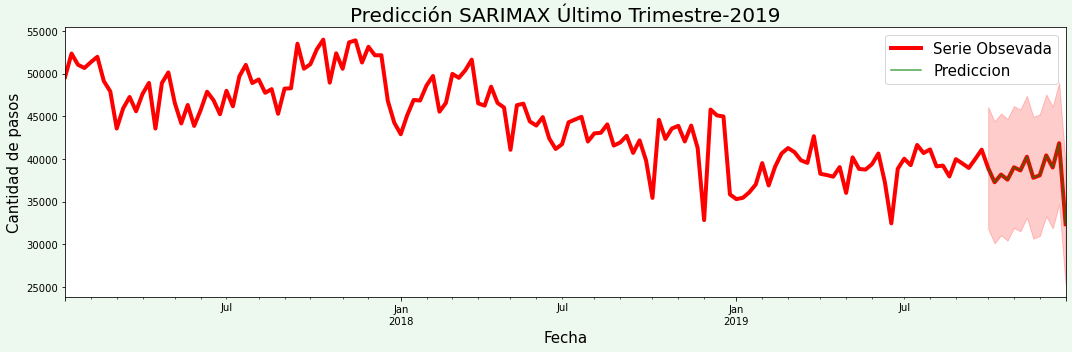

In [76]:
pred = results.get_prediction(start=datetime.datetime(2019,10,6), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='Serie Obsevada',color='red',lw = 4,figsize=(15,5))

pred.predicted_mean.plot(ax=ax, label='Prediccion', alpha=.7, color='green')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.2)
plt.title("Predicción SARIMAX Último Trimestre-2019", color= 'black', fontsize=20)
ax.set_xlabel('Fecha',fontsize=15)
ax.set_ylabel('Cantidad de pasos',fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

Podemos Observar una buena prediccion para el ultimo trimestre 2019. Veamos el error.

In [77]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-10-06':]


rmse_so = np.sqrt(mean_squared_error(y_truth,y_forecasted ))
print(f'RMSE de SARIMAX One-Step es: {rmse_so }')

RMSE de SARIMAX One-Step es: 18.136280643054913


### PREDICCION 2020

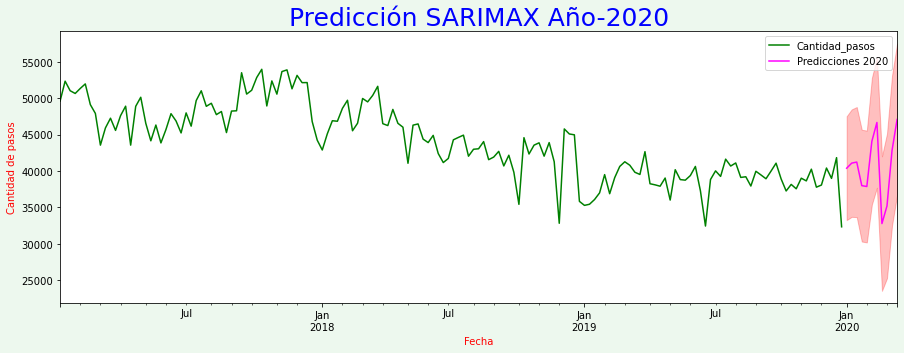

In [78]:
#graficando desde el 2017
pred_uc = results.get_forecast(steps=datetime.datetime(2020,3,15))
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Cantidad_pasos', color='green',figsize=(15,5))
pred_uc.predicted_mean.plot(ax=ax, label='Predicciones 2020', color='magenta')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.25)
plt.title("Predicción SARIMAX Año-2020", color= 'blue', fontsize=25)
ax.set_xlabel('Fecha', color='red')
ax.set_ylabel('Cantidad de pasos', color='red')

plt.legend()
plt.show()

In [79]:
# Prediccion Sarimax
y_s_2020=pred_uc.predicted_mean
# 1º trimestre 2020 del 05/01/2020 al 15/03/2020 antes que empiece la cuarentena. Datos AUSA
fecha_i='2020-01-05'
fecha_f='2020-03-15'
y_2020=semanal_2020_m[(semanal_2020_m.index >=fecha_i)&(semanal_2020_m.index <=fecha_f)]



b_rmse=np.sqrt(mean_squared_error(y_2020, y_s_2020))

---------------------------------
RMSE en Benchmark: 7775.620388001718
---------------------------------


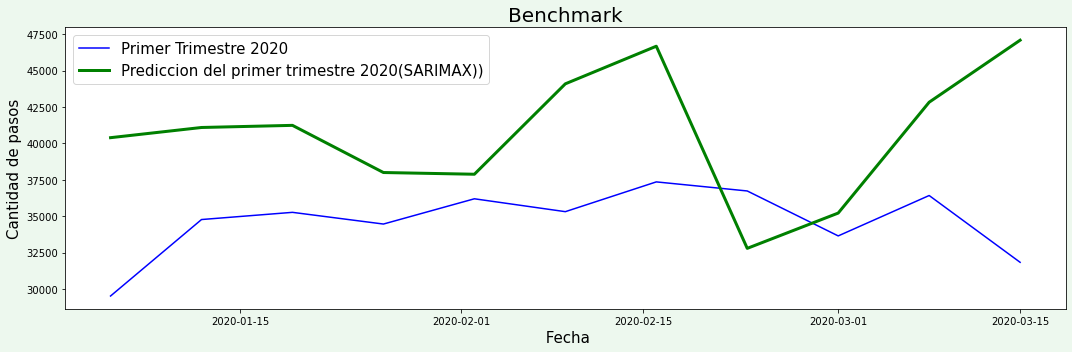

In [82]:
print('---------------------------------')
print(f'RMSE en Benchmark: {b_rmse}')
print('---------------------------------')

plt.figure(figsize=(15,5))
plt.plot(y_2020.index, y_2020.cantidad_pasos,color='blue', label='Primer Trimestre 2020')
plt.plot(y_s_2020.index, y_s_2020, lw=3, color='green',label='Prediccion del primer trimestre 2020(SARIMAX))')
plt.title ('Benchmark', fontsize=20)
plt.xlabel(' Fecha',fontsize=15)
plt.ylabel('Cantidad de pasos',fontsize=15)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

La prediccion Sarimax 2020 no fue buena. La pandemia y la cuarentena dictada el 15/03/2020 fue un evento imprevisto que nos dificulta una correcta prediccion, casi transformando este año en un outlier es por eso que se considera la primer quincena de marzo donde todavia viviamos en normalidad.
El supuesto de que el futuro se comportara de forma similar al pasado en este caso no se aplico y nos hace ver que hay que tener cuidado con estos supuestos.
A esta situación tan excenpcional deberiamos sumarle la migración a la forma de pago telepase, que con todos beneficios que impulsaron posiblemente sea una forma de pago que se vaya a instalar con mucha fuerza.
Probaremos con un modelo de la libreria fbProphet para ver si podemos mejorar las prediccion para el 2020.

### PROPHET
Prophet una biblioteca para pronósticos de series de tiempo lanzada por Facebook. Se desarrolló inicialmente con el propósito de crear pronósticos comerciales de alta calidad. Esta biblioteca intenta abordar las siguientes dificultades comunes a muchas series de tiempo comerciales:

-Efectos esta cionales provocados por el comportamiento humano: ciclos semanales, mensuales y anuales, caídas y picos en días festivos. 

-Cambios de tendencia debido a nuevos productos y eventos del mercado.

In [83]:
from fbprophet import Prophet

Convirtamos nuestros datos al formato requerido por Prophet:

In [84]:
semanal_m_1 = semanal_m.copy()
semanal_m_1.reset_index(level=0, inplace=True)
semanal_m_1= semanal_m_1.rename(columns={'fecha': 'ds',
                        'cantidad_pasos': 'y'})
semanal_m_1.head()

,ds,y
0,2017-01-08,49601.714286
1,2017-01-15,52344.714286
2,2017-01-22,51030.714286
3,2017-01-29,50654.428571
4,2017-02-05,51343.000000


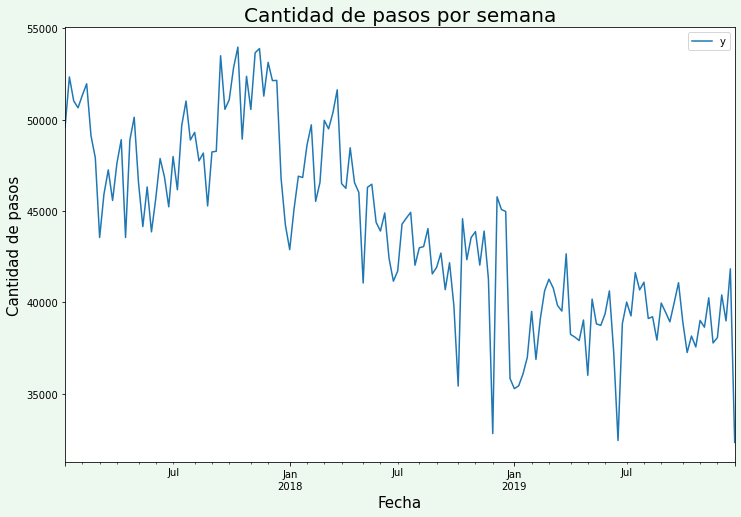

In [87]:
ax = semanal_m_1.set_index('ds').plot(figsize=(12, 8))
plt.title("Cantidad de pasos por semana", fontsize= 20)
ax.set_ylabel('Cantidad de pasos',fontsize= 15 )
ax.set_xlabel('Fecha',fontsize= 15 )
plt.show()


In [88]:
#definimos intervalo de confianza y entrenamos
prophet_model = Prophet(interval_width= 0.95 )
prophet_model.fit(semanal_m_1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
#creamos data con predicciones
future_dates = prophet_model.make_future_dataframe(periods=11, freq='W')
future_dates.head()

,ds
0,2017-01-08
1,2017-01-15
2,2017-01-22
3,2017-01-29
4,2017-02-05


In [90]:
#predecimos
forecast = prophet_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-08,45944.694858,41279.121208,50061.533179
1,2017-01-15,46893.733409,42425.798137,51395.585343
2,2017-01-22,48778.904394,44542.159849,53219.238285
3,2017-01-29,50082.764317,45585.949899,54786.599055
4,2017-02-05,50171.002908,45902.132142,54643.484266


In [91]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
162,2020-02-16,36006.669489,31705.432694,40497.433692
163,2020-02-23,35657.488105,31213.517584,40034.630242
164,2020-03-01,35826.197262,31339.271911,40311.978020
165,2020-03-08,36206.616802,31740.301193,40479.636262
166,2020-03-15,36451.993649,31979.195675,40969.073907


Graficamos las predicciones

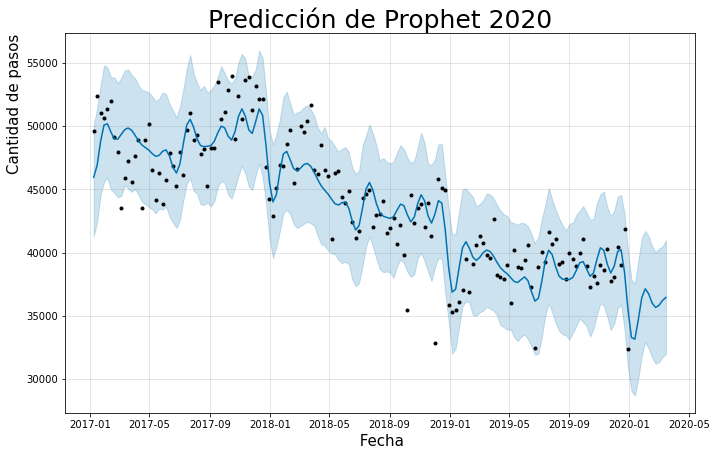

In [92]:
fig1 = prophet_model.plot(forecast)
plt.title("Predicción de Prophet 2020", fontsize=25)
plt.xlabel(' Fecha', fontsize=15)
plt.ylabel('Cantidad de pasos', loc= 'top', fontsize=15)
plt.show()

Los puntos negros que indican los puntos de datos utilizados para entrenar el modelo. La línea azul traza la predicción.
La función traza los intervalos de incertidumbre.

Vamos a utilizar tambien la funcion Prophet.plot_components que nos permite observar diferentes componentes del modelo por separado: tendencia, estacionalidad anual y semanal.



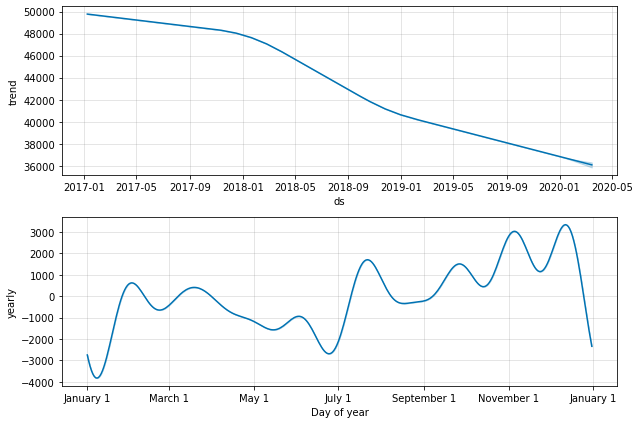

In [94]:
 prophet_model.plot_components(forecast);

Corroboramos la tendencia en baja

### PARTE C

### Contrastamos los Modelos 

In [95]:
prophet_2019_p = forecast[(forecast.ds >= "2019-10-06") & (forecast.ds <= "2019-12-29")]
prophet_2019_p.drop(columns=["trend", "yhat_lower", "yhat_upper",
                       "trend_lower", "trend_upper", "additive_terms",
                       "additive_terms_lower", "additive_terms_upper",
                       "yearly", "yearly_lower", "yearly_upper", 
                       "multiplicative_terms", "multiplicative_terms_lower", 
                       "multiplicative_terms_upper"], inplace= True)
prophet_2019_p.rename(columns={'ds':'fecha', "yhat":'cantidad_pasos'}, inplace=True)
prophet_2019_p = prophet_2019_p.set_index('fecha')
prophet_2019_p

C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,cantidad_pasos
fecha,
2019-10-06,38701.767618
2019-10-13,38123.784128
2019-10-20,38386.171748
2019-10-27,39473.706892
2019-11-03,40380.324389
2019-11-10,40168.514234
2019-11-17,39084.557853
2019-11-24,38382.178221
2019-12-01,38922.849406


In [96]:
y_o_2019=semanal_m[(semanal_m.index >='2019-10-06')&(semanal_m.index <='2019-12-29')]
y_o_2019

,cantidad_pasos
fecha,
2019-10-06,38926.142857
2019-10-13,37262.857143
2019-10-20,38163.857143
2019-10-27,37564.285714
2019-11-03,39018.428571
2019-11-10,38648.000000
2019-11-17,40255.714286
2019-11-24,37785.714286
2019-12-01,38079.285714


In [97]:
pred = results.get_prediction(start=datetime.datetime(2019,10,6), dynamic=False)
sarimax_2019_p= pred.predicted_mean
sarimax_2019_p = pd.DataFrame(sarimax_2019_p)

sarimax_2019_p.rename(columns={"predicted_mean":'cantidad_pasos'}, inplace=True)


sarimax_2019_p = sarimax_2019_p.set_index(sarimax_2019_p.index)

sarimax_2019_p

,cantidad_pasos
fecha,
2019-10-06,38945.406671
2019-10-13,37240.631828
2019-10-20,38186.768615
2019-10-27,37551.632596
2019-11-03,39048.460897
2019-11-10,38646.389857
2019-11-17,40270.077983
2019-11-24,37781.408078
2019-12-01,38093.972860


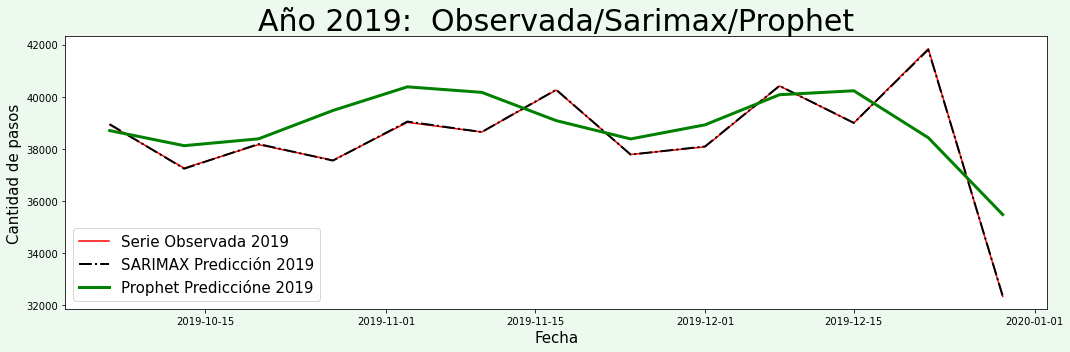

RMSE de PROPHET  es: 1622.5815479045243
RMSE de SARIMAX One-Step es: 18.136280643054913


In [98]:
#graficamos

plt.figure(figsize=(15,5))

plt.plot(y_o_2019.index, y_o_2019.cantidad_pasos,color='red', label='Serie Observada 2019')
plt.plot(sarimax_2019_p.index, sarimax_2019_p.cantidad_pasos,'-.',lw=2, color='black',label='SARIMAX Predicción 2019')
plt.plot(prophet_2019_p.index, prophet_2019_p.cantidad_pasos, lw=3, color='green',label='Prophet Prediccióne 2019')

plt.title ('Año 2019:  Observada/Sarimax/Prophet',fontsize=30)
plt.xlabel('Fecha',fontsize=15)
plt.ylabel('Cantidad de pasos',fontsize=15)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

y_p_pro=  prophet_2019_p.cantidad_pasos
y= y_o_2019.cantidad_pasos
rmse_pro = np.sqrt(mean_squared_error(y,y_p_pro))

print(f'RMSE de PROPHET  es: {rmse_pro }')
print(f'RMSE de SARIMAX One-Step es: {rmse_so }')

Como observamos en la grafica y en las metricas la prediccion de Sarimax es muy superadora a Prophet. Veamos que pasa para el 2020

In [99]:
#data 2020
prophet_2020_p =forecast[(forecast.ds >= "2020-01-05") & (forecast.ds <= "2020-03-15")]
prophet_2020_p.drop(columns=["trend", "yhat_lower", "yhat_upper",
                       "trend_lower", "trend_upper", "additive_terms",
                       "additive_terms_lower", "additive_terms_upper",
                       "yearly", "yearly_lower", "yearly_upper", 
                       "multiplicative_terms", "multiplicative_terms_lower", 
                       "multiplicative_terms_upper"], inplace= True)
prophet_2020_p.rename(columns={'ds':'fecha', "yhat":'cantidad_pasos'}, inplace=True)
prophet_2020_p = prophet_2020_p.set_index('fecha')
prophet_2020_p

C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Fabiana\miniconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,cantidad_pasos
fecha,
2020-01-05,33291.220527
2020-01-12,33152.485960
2020-01-19,34698.166114
2020-01-26,36431.206102
2020-02-02,37134.618754
2020-02-09,36737.478993
2020-02-16,36006.669489
2020-02-23,35657.488105
2020-03-01,35826.197262


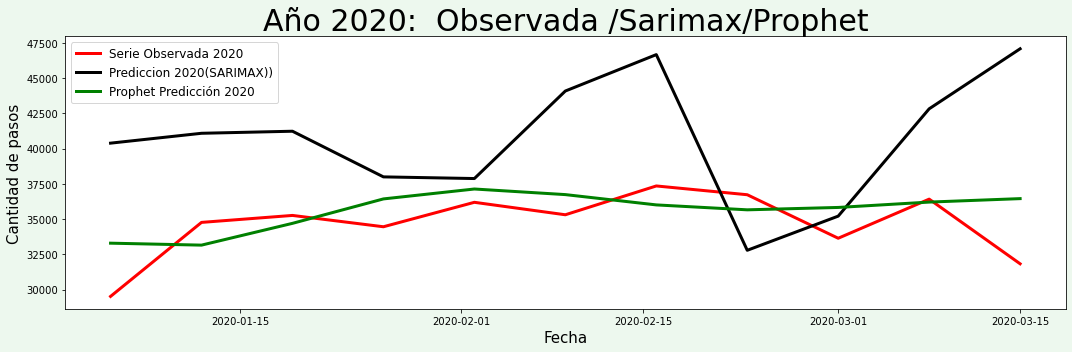

RMSE de PROPHET  es: 2198.9288031632004
RMSE en Benchmark (Sarimax One-Step): 7775.620388001718


In [100]:
# Prediccion Sarimax: Modelo Benchmark
y_s_2020=pred_uc.predicted_mean
# 1º trimestre 2020 del 05/01/2020 al 15/03/2020 antes que empiece la cuarentena. Datos AUSA
fecha_i='2020-01-05'
fecha_f='2020-03-15'
y_2020=semanal_2020_m[(semanal_2020_m.index >=fecha_i)&(semanal_2020_m.index <=fecha_f)]
plt.figure(figsize=(15,5))

plt.plot(y_2020.index, y_2020.cantidad_pasos,color='red',lw=3, label='Serie Observada 2020')
plt.plot(y_s_2020.index, y_s_2020, lw=3, color='black',label='Prediccion 2020(SARIMAX))')
plt.plot(prophet_2020_p.index, prophet_2020_p.cantidad_pasos,lw=3 , color='green',label='Prophet Predicción 2020')

plt.title ('Año 2020:  Observada /Sarimax/Prophet', fontsize=30)
plt.xlabel('Fecha',fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

y_pro_p=  prophet_2020_p.cantidad_pasos
y= y_2020.cantidad_pasos
rmse_pro_20 = np.sqrt(mean_squared_error(y,y_pro_p))

print(f'RMSE de PROPHET  es: {rmse_pro_20 }')
print(f'RMSE en Benchmark (Sarimax One-Step): {b_rmse}')# Prediccion hecha con Sarimax

En este caso vemos que Prophet predijo mejor los datos de primer trimestre para el 2020, tambien vemos que la metrica del error es mucho mas baja.

### Conclusiones
En este Proyecto implementamos modelos que no aplicamos en el Poyecto n° 3. 
Pudimos observar que la performance de los modelos fue muy diferente en la serie 2019 y 2020. Siendo un mejor modelo Sarimax para 2019 y Prophet pudo predecir mejor 2020. Quiza en esta ultima libreria haya una mejor adaptacion a valores atipicos que en un modelo clasico como SARIMAX que en cambio muy buen predictor para los datos de la serie 2019.